# Projeto de Software Quântico  - Memória Associativa
## Parte 1 - Algoritmo de Grover (3.1)

#### Imports

In [1]:
%pip install qiskit qiskit-aer
%pip install matplotlib
%pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\msoli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\msoli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\msoli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# imports principais (circuito quântico, transpile/compilador, simulador quântico local, histograma, statevector para análise)
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation

# imports para a matemática e visualização
import numpy as np
import matplotlib.pyplot as plt

#### Parâmetros Globais

In [3]:
n_qubits = 3              # padrão mínimo demonstrativo - chega a 8 estados
target_state = "101"      # força o oracle a lidar com padrões mistos e inverter fase em qubits diferentes
shots = 1024              # 2^10 - equiliíbro ideal entre estatística e custo computacional

#### Função base de circuito - cria um circuito novo sempre que precisar

In [4]:
def create_base_circuit(n):
    # cria um circuito quântico com n qubits e n bits clássicos para medição
    qc = QuantumCircuit(n, n) 
    return qc

    

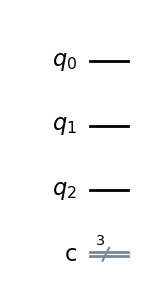

In [5]:
# teste de criação do circuito base
qc = create_base_circuit(n_qubits)
qc.draw("mpl")

### Superposição Uniforme

In [6]:
# aplicar a porta Hadamard em todos os qubits para criar superposição
def apply_hadamard_all(qc, n): 
    for i in range(n):  # loop para aplicar a porta Hadamard em cada qubit; i representa o índice do qubit 
        qc.h(i) # aplica a porta Hadamard no qubit i, colocando-o em superposição
    return qc # retorna o circuito atualizado com as portas Hadamard aplicadas a todos os qubits

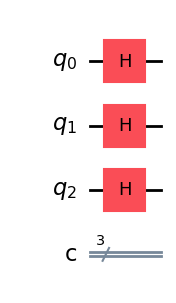

In [7]:
qc = create_base_circuit(n_qubits) 
qc = apply_hadamard_all(qc, n_qubits)

qc.draw("mpl")

### Oráculo - Inversão de fase

#### Propriedades desejadas:
##### 1. Usar portas quânticas reversíveis
##### 2. Alterar fases
##### 3. Marcar exatamente um subconjunto de dados

In [8]:
# o oráculo troca a fase do estado alvo, para que ele se destaque na interferência construtiva do algoritmo de Grover
# Toffoli gate é uma operação multi-qubit que inverte o estado do qubit alvo apenas quando todos os qubits de controle estão em estado |1> 
def apply_oracle(qc, target):
    n = len(target) 
    for i in range(n):
        if target[i] == '0':  # se o bit do estado alvo for 0, aplicamos uma porta X para inverter o qubit porque o controle da porta Toffoli é ativado quando os qubits estão em estado |1>
            qc.x(i) # aplica a porta X no qubit i para inverter seu estado, preparando-o para o controle da porta Toffoli
    qc.h(n-1)  # aplica a porta Hadamard no último qubit para preparar para a porta de controle
    qc.mcx(list(range(n-1)), n-1)  # aplica a porta Toffoli controlada por todos os qubits exceto o último
    qc.h(n-1)  # aplica a porta Hadamard novamente para restaurar o estado do último qubit
    for i in range(n):
        if target[i] == '0':  
            qc.x(i)
    return qc  


In [9]:
# teste do oráculo para verificar se ele inverte a fase do estado alvo corretamente
qc_test = create_base_circuit(n_qubits)
qc_test = apply_hadamard_all(qc_test, n_qubits)
qc_test = apply_oracle(qc_test, target_state)

state = Statevector.from_instruction(qc_test)
print(state)

Statevector([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j],
            dims=(2, 2, 2))


### Difusão - Reflexão na média

In [10]:
# Diffusion operator (inversão sobre a média) para amplificar a probabilidade do estado alvo    
def apply_diffusion(qc, n):
    qc.h(range(n))  # aplica a porta Hadamard em todos os qubits para criar superposição
    qc.x(range(n))  # aplica a porta X em todos os qubits para inverter seus estados
    qc.h(n-1)       # aplica a porta Hadamard no último qubit para preparar para a porta de controle
    qc.mcx(list(range(n-1)), n-1)  # aplica a porta Toffoli controlada por todos os qubits exceto o último
    qc.h(n-1)       # aplica a porta Hadamard novamente para restaurar o estado do último qubit
    qc.x(range(n))  # aplica a porta X novamente para restaurar os estados originais dos qubits
    qc.h(range(n))  # aplica a porta Hadamard novamente para finalizar a inversão sobre a média
    return qc
# isso resulta em # D = H^{⊗n} X^{⊗n} MCZ X^{⊗n} H^{⊗n} onde ⊗ significa a aplicação da operação em todos os qubits, e MCZ é a porta de controle que inverte a fase do estado |11...1> (todos os qubits em estado |1>)

In [11]:
# teste do operador de difusão para verificar se ele amplifica a probabilidade do estado alvo corretamente
qc_test = create_base_circuit(n_qubits)
qc_test = apply_hadamard_all(qc_test, n_qubits)
qc_test = apply_oracle(qc_test, target_state)
qc_test = apply_diffusion(qc_test, n_qubits)

state = Statevector.from_instruction(qc_test)
print(state)

Statevector([-0.1767767 +0.j, -0.1767767 +0.j, -0.1767767 +0.j,
             -0.1767767 +0.j, -0.1767767 +0.j, -0.88388348+0.j,
             -0.1767767 +0.j, -0.1767767 +0.j],
            dims=(2, 2, 2))


### Iterações

In [12]:
# número ótimo de iterações r para maximizar a probabilidade de encontrar o estado alvo é aproximadamente π/4 * √N, onde N é o número total de estados possíveis (2^n_qubits)
N = 2**n_qubits
r = int(np.pi/4 * np.sqrt(N))

print("Espaço de busca N =", N)
print("Número ótimo de iterações r =", r)

Espaço de busca N = 8
Número ótimo de iterações r = 2


### Implementação do Algoritmo de Grover

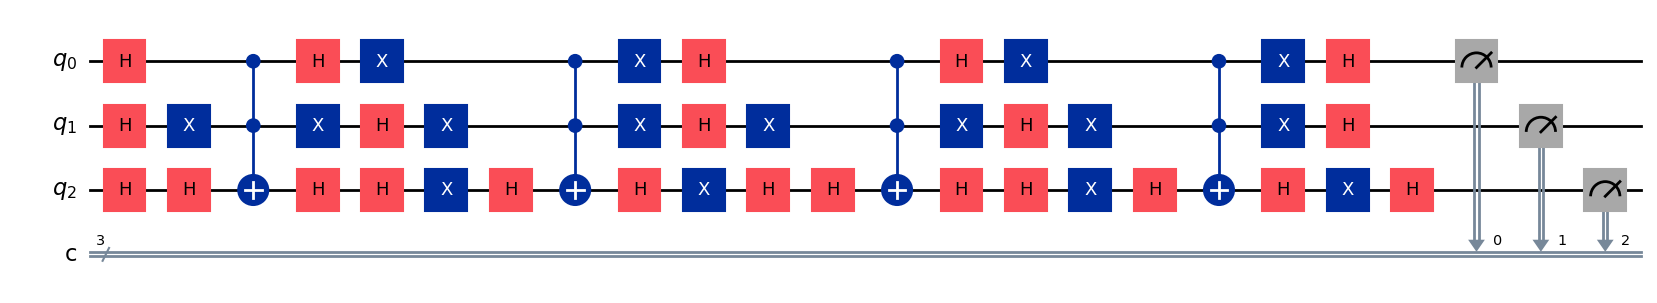

In [13]:
# construção completa
qc = create_base_circuit(n_qubits) # cria o circuito base com n qubits e n bits clássicos
qc = apply_hadamard_all(qc, n_qubits) # aplica a porta Hadamard em todos os qubits para criar superposição
for _ in range(r): # loop para aplicar o oráculo e o operador de difusão
    qc = apply_oracle(qc, target_state) # aplica o oráculo para inverter a fase do estado alvo
    qc = apply_diffusion(qc, n_qubits) # aplica o operador de difusão para amplificar a probabilidade do estado alvo

# medição 
qc.measure(range(n_qubits), range(n_qubits)) # mede todos os qubits e armazena os resultados nos bits clássicos correspondentes
qc.draw("mpl")

Contagem de resultados: {'101': 981, '001': 4, '011': 4, '100': 11, '111': 4, '110': 6, '000': 5, '010': 9}


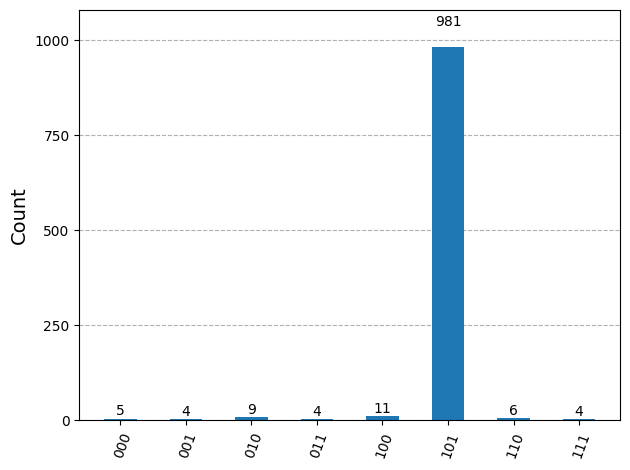

In [14]:
# execução no simulador local
simulator = Aer.get_backend('qasm_simulator') # seleciona o backend do simulador
compiled_qc = transpile(qc, simulator) # transpila o circuito para o formato do simulador

job = simulator.run(compiled_qc, shots=shots) # executa o circuito no simulador com o número de shots definido
result = job.result() # obtém os resultados da execução
counts = result.get_counts(compiled_qc) # obtém a contagem de cada resultado medido

print("Contagem de resultados:", counts)
plot_histogram(counts) 

In [15]:
# função para executar o algoritmo de Grover com um número diferente de iterações e retornar os resultados 
def run_grover_iterations(num_iterations):
    
    qc = create_base_circuit(n_qubits) # Superposição inicial
    qc = apply_hadamard_all(qc, n_qubits) # Aplicar Grover num_iterations vezes
    for _ in range(num_iterations):
        qc = apply_oracle(qc, target_state)
        qc = apply_diffusion(qc, n_qubits)
    
    # Medição
    qc.measure(range(n_qubits), range(n_qubits))
    
    # Execução
    simulator = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=shots)
    result = job.result()
    
    return result.get_counts()

# Grover não converge, cada iteração adiciona rotação e ao passar do ponto ótimo, a probabilidade do estado alvo começa a diminuir
# então é importante escolher o número certo de iterações para maximizar a probabilidade de encontrar o estado alvo.


In [16]:
for k in [r-1, r, r+1]:
    counts = run_grover_iterations(k)
    print(f"\nIterações = {k}")
    print(counts)
    plot_histogram(counts)


Iterações = 1
{'100': 29, '101': 800, '110': 41, '001': 29, '011': 26, '111': 34, '010': 30, '000': 35}

Iterações = 2
{'101': 974, '011': 9, '010': 5, '110': 8, '111': 8, '000': 9, '100': 8, '001': 3}

Iterações = 3
{'000': 91, '101': 335, '011': 116, '100': 88, '010': 97, '110': 94, '001': 98, '111': 105}


## Parte 2 - Preparação de Estados - Ventura & Martinez (3.2)


### Parâmetros Globais da Preparação de Estados

In [17]:
# parâmetros - preparação para a preparação de estados 
P = ["001", "101", "111"]   # conjunto de padrões armazenados
M = len(P)                  # tamanho do subconjunto

### Função prepare_states

In [18]:
# preparação do estado quântico com padrões definidos em P(memória associativa)
# construção da superposição restrita que atua apenas no subconjunto P, pois o Grover precisa amplificar a probabilidade apenas dos estados que estão na 
# memória para ser eficiente, em vez de amplificar a probabilidade de todos os estados possíveis, 
# o que pode diluir a probabilidade do estado alvo e reduzir a eficiência do algoritmo.
def prepare_states(qc, patterns): 

    state = np.zeros(2**n_qubits)

    for pattern in patterns:
        index = int(pattern, 2) # conversão para binário para obter o índice correspondente no vetor de estado
        state[index] = 1 # atribui amplitude 1 ao estado correspondente ao padrão, indicando que ele está presente na memória

    # deixar aqui fora do loop para normalizar o vetor de estado apenas uma vez, após atribuir as amplitudes para todos os padrões
    state = state / np.linalg.norm(state) 

    qc.initialize(state, range(n_qubits))

    return qc

In [19]:
# teste da preparação de estados para verificar se os padrões são preparados corretamente
qc_state = create_base_circuit(n_qubits) # cria o circuito base com n qubits e n bits clássicos
qc_state = prepare_states(qc_state, P) # prepara o circuito com os padrões definidos em P usando a função prepare_states

state = Statevector.from_instruction(qc_state) # converte o circuito preparado em um vetor de estado para análise
print(state)

Statevector([0.        +0.j, 0.57735027+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.57735027+0.j,
             0.        +0.j, 0.57735027+0.j],
            dims=(2, 2, 2))


In [20]:
# verificação se o estado alvo está armazenado na memória P 
# o algoritmo de Grover precisa saber se o estado alvo está presente na memória para funcionar corretamente, 
# pois ele depende da estrutura do espaço de busca para amplificar a probabilidade do estado alvo. 
if target_state in P:
    print("O estado alvo está armazenado na memória P.")
else:
    print("O estado alvo NÃO está armazenado na memória P.")

O estado alvo está armazenado na memória P.


## Parte 2.1 - Aplicar ao Grover Original

### Remover o Hadamard Global

In [21]:
# remover o Hadamard Global porque a preparação de estados já cria uma superposição restrita apenas dos padrões armazenados
qc = create_base_circuit(n_qubits)
qc = prepare_states(qc, P)

### Novo número ótimo r_P

In [22]:
# calcular um novo r para que o número de iterações seja adequado ao tamanho do subconjunto P
# r se define como r = int(np.pi/4 * np.sqrt(M)) onde M é o número de padrões armazenados na memória P, 
# para garantir que o algoritmo de Grover amplifique a probabilidade dos estados presentes na memória de forma eficiente, 
# sem amplificar estados que não estão na memória, o que poderia diluir a probabilidade do estado alvo e reduzir a eficiência do algoritmo.
r_P = int(np.pi/4 * np.sqrt(M)) # fórmula para calcular o número ótimo de iterações r, onde M é o número de padrões armazenados na memória P  
print("Iterações (subespaço P):", r_P)

Iterações (subespaço P): 1


### Oracle + Diffusion

{'101': 535, '001': 177, '111': 200, '000': 17, '010': 25, '011': 24, '110': 27, '100': 19}


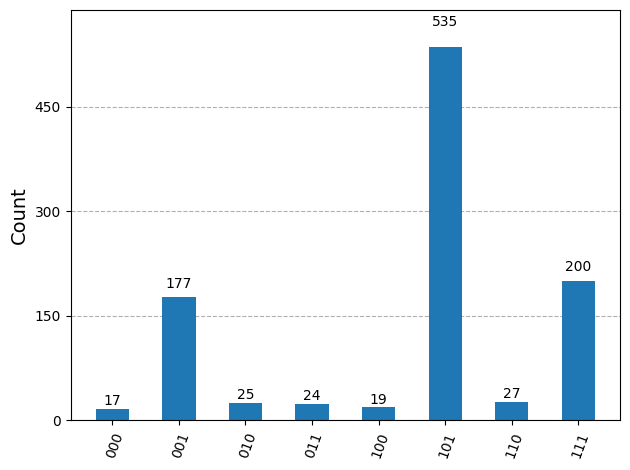

In [23]:
# reaproveitar os mesmos operadores
# ainda deixar global pois ainda estamos na fase de preparação de estados
for _ in range(r_P):
    qc = apply_oracle(qc, target_state)
    qc = apply_diffusion(qc, n_qubits)

# medir 
qc.measure(range(n_qubits), range(n_qubits)) # mede todos os qubits e armazena os resultados nos bits clássicos correspondentes

# nesta etapa executamos o algoritmo de Grover utilizando estado inicial restrito, porém mantendo o operador de difusão global. 
# o objetivo é avaliar se a mudança do estado inicial é suficiente para garantir amplificação correta.

simulator = Aer.get_backend('qasm_simulator')

compiled = transpile(qc, simulator)
job = simulator.run(compiled, shots=1024)

result = job.result()
counts_part2 = result.get_counts()

print(counts_part2)
plot_histogram(counts_part2)

# porém, estados fora de P ainda aparecem, a amplificação não é tão eficiente quanto poderia ser, pois o operador de difusão global 
# ainda amplifica a probabilidade de estados que não estão na memória, diluindo a probabilidade do estado alvo e reduzindo a eficiência do algoritmo.
# logo, apenas mudar estado inicial não é o suficiente

## Parte 3 - Ajuste do Algoritmo de Grover (3.3)
### O operador de difusão global reflete no estado uniforme total, enquanto o estado inicial pertence a um subespaço restrito. Isso desalinha as reflexões. Para corrigir, substituímos o difusor por uma reflexão em torno do estado preparado |ψ_P⟩. ------ DP​=2∣ψP​⟩⟨ψP​∣−I

### Operador de Preparação


In [24]:
n_qubits = 3

In [25]:
# o operador de preparação de estados é uma etapa crucial para garantir que o algoritmo de Grover funcione corretamente em um cenário de memória associativa,
# pois ele define o espaço de busca e a estrutura do estado quântico, permitindo que o algoritmo amplifique a probabilidade dos estados presentes 
# na memória de forma eficiente
def create_preparation_operator(patterns, n_qubits):

    state = np.zeros(2**n_qubits)

    for pattern in patterns:
        index = int(pattern, 2)
        state[index] = 1

    state = state / np.linalg.norm(state)

    return StatePreparation(state)  # ← retorne o gate direto

### Difusão Restrita

In [26]:
# em comparação a outra difusão, a difusão restrita ao subespaço P, que amplifica apenas os estados presentes na memória, 
# enquanto a difusão global amplifica a probabilidade de todos os estados possíveis,
# o que pode diluir a probabilidade do estado alvo e reduzir a eficiência do algoritmo.

def apply_restricted_diffusion(qc, patterns, n_qubits):
    # criar o operador de preparação de estados para o subespaço P
    prep = create_preparation_operator(patterns, n_qubits) 
    
    # FIX: Decompor o operador inverso para evitar crash no simulador
    # O simulador Aer pode ter problemas com a instrução StatePreparation direta em alguns contextos
    prep_dagger = prep.inverse()
    temp_qc_dagger = QuantumCircuit(n_qubits)
    temp_qc_dagger.append(prep_dagger, range(n_qubits))
    # Transpilar para portas básicas para garantir que o simulador processe corretamente
    decomposed_dagger = transpile(temp_qc_dagger, basis_gates=['u', 'cx', 'id', 'rz', 'sx', 'x'])
    
    qc.compose(decomposed_dagger, inplace=True)
    
    # aplicar a difusão global no estado preparado, que agora é restrito ao subespaço P
    qc.x(range(n_qubits)) # inverte os estados para preparar para a porta de controle
    qc.h(n_qubits - 1) # prepara o último qubit para a porta de controle
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1) # aplica a porta de controle
    qc.h(n_qubits - 1) # restaura o estado do último qubit
    qc.x(range(n_qubits)) # restaura os estados originais dos qubits
    
    # FIX: Decompor o operador normal também
    temp_qc_prep = QuantumCircuit(n_qubits)
    temp_qc_prep.append(prep, range(n_qubits))
    decomposed_prep = transpile(temp_qc_prep, basis_gates=['u', 'cx', 'id', 'rz', 'sx', 'x'])
    
    qc.compose(decomposed_prep, inplace=True)

    return qc

### Grover ajustado

{'001': 42, '101': 938, '111': 44}


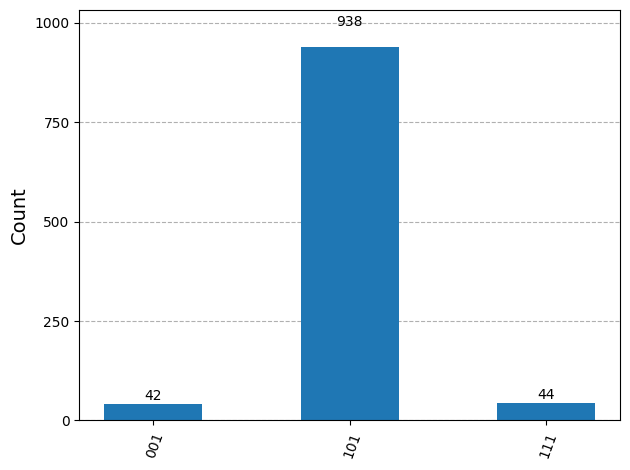

In [27]:
# aqui o Grover é ajustado para que o operador de difusão seja restrito ao subespaço P, amplificando apenas os estados presentes na memória,
# o que aumenta a eficiência do algoritmo, pois evita amplificar estados que não estão na memória, garantindo que a 
# probabilidade do estado alvo seja maximizada de forma mais eficaz.
# logo, o Grover é ajustado por meio da função apply_restricted_diffusion, que utiliza o operador de preparação de estados para 
# criar uma difusão restrita ao subespaço P, amplificando apenas os estados presentes na memória. 

# importação da classe StatePreparation para criar o operador de preparação de estados a partir do vetor de estado definido pela função create_preparation_operator
from qiskit.circuit.library import StatePreparation 
qc_adj = create_base_circuit(n_qubits) 
qc_adj = prepare_states(qc_adj, P) 

for _ in range(r_P):
    qc_adj = apply_oracle(qc_adj, target_state)
    qc_adj = apply_restricted_diffusion(qc_adj, P, n_qubits)

qc_adj.measure(range(n_qubits), range(n_qubits))

# Execução
compiled = transpile(qc_adj, simulator)
job = simulator.run(compiled, shots=1024)

result = job.result()
counts_part3 = result.get_counts()

print(counts_part3)
plot_histogram(counts_part3)

### Comparações finais